## How to build a simple Stock Movement Classifier

In [47]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

from ta import add_all_ta_features

import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

import sys
sys.path.append("..") 
from tp_utils.data_provider import read_prices, read_data

### 1. Data load

In [3]:
market = 'SOL-USDC'
tf = '5m'

df_raw = read_data(market, tf)
assert df_raw[df_raw.isna()==True].sum().sum() == 0

In [4]:
df_raw.tail()

,T,O,H,L,C,V
48872,1710780000000,203.73,204.14,203.21,203.26,402.007
48873,1710780300000,203.26,203.31,200.51,200.65,791.055
48874,1710780600000,200.65,200.80,198.04,198.34,1672.129
48875,1710780900000,198.34,199.89,198.00,199.45,661.061
48876,1710781200000,199.45,199.61,197.76,197.89,484.278


In [7]:
df = df_raw[-10000:].copy()

Проверяем mean, median. Если не равны, распределение кривое или есть выбросы

In [50]:
df.describe()

,T,O,H,L,C,V
count,1.000000000e+04,10000.000000000,10000.000000000,10000.000000000,10000.000000000,10000.000000000
mean,1.709281350e+12,60347.135645000,60425.184646000,60264.794617000,60348.844717000,27.704863372
std,8.660687040e+08,8025.765382387,8050.995493125,7997.235847371,8025.387731757,28.075453666
min,1.707781500e+12,48472.410000000,48505.000000000,48305.960000000,48472.410000000,0.726360000
25%,1.708531425e+12,51774.095000000,51816.520000000,51732.287500000,51774.225000000,12.225681250
50%,1.709281350e+12,61910.890000000,61966.885000000,61849.780000000,61911.835000000,20.609607500
75%,1.710031275e+12,67923.805000000,68037.122500000,67780.820000000,67923.805000000,33.837112000
max,1.710781200e+12,73671.910000000,73830.210000000,73610.640000000,73671.910000000,487.208077000


In [51]:
df[['H', 'L', 'C']].apply(np.log).diff()

,H,L,C
38877,NaN,NaN,NaN
38878,0.000203955,0.000398988,0.000328830
38879,-0.000344610,-0.001836263,-0.001824823
38880,-0.001439655,-0.000043871,0.000459420
38881,0.002072447,0.000889671,0.000554826
...,...,...,...
48872,0.001795470,0.000764786,-0.001206991
48873,-0.002697961,-0.004972536,-0.004704781
48874,-0.004399029,-0.004471408,-0.004670779
48875,-0.003593457,-0.001384643,0.001183189


### 2. Feature engineering
#### Определяем несколько таргетов

volatility, Объем, TA, returns

In [5]:
def get_features(df):
    '''This function takes the historical OHLC data and return features as we defined above
    
    Parameters
    ----------
    df : DataFrame
        Dataframe containing pricing data
        
    Returns
    -------
    pandas DataFrame containing features except categorical features
    '''
    
    features = df.copy()
    #creating features as stated above
    features["Force_Index"] = df["C"] * df["V"]
    features['H_rets'] = features['H'].apply(np.log).diff() 
    features['L_rets'] = features['L'].apply(np.log).diff() 
    features['C_rets'] = features['C'].apply(np.log).diff() 
    features['SMA_2'] = features['C'].rolling(window=2).mean()
    features['SMA_5'] = features['C'].rolling(window=2).mean()
    features['SMA_20'] = features['C'].rolling(window=20).mean()
    features['Std_20'] = features['C'].rolling(window=20).std()
    features['Band_1'] = features['SMA_20'] - features['Std_20']
    features['Band_2'] = features['SMA_20'] + features['Std_20']
    features['dist_from_mean'] = features['C'] - features['SMA_20']
    features['ON_returns'] = features['C'] - features['O']
    features['ON_returns_signal'] = np.where(features['ON_returns'] <0, 'up', 'down')

  

    comb_features = pd.get_dummies(features, columns=['ON_returns_signal']) #for categorical variables
    comb_features = comb_features.drop(['T', 'H', 'L', 'ON_returns'], axis=1) #dropping original categorical column
    
    ###Create return column to predict
    for shift in [1,3,7]:
        comb_features['target_' + str(shift)] = np.sign(features['C'].diff(shift).shift(-shift))
        comb_features['target_' + str(shift)] = np.where(comb_features['target_' + str(shift)] > 0, "Buy", "Sell")

    comb_features = comb_features.fillna(0)
    return  comb_features

In [55]:
features = add_all_ta_features(df, open="O", high="H", low="L", close="C", volume="V")
features = get_features(df)


In [56]:
features

,O,C,V,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,...,SMA_20,Std_20,Band_1,Band_2,dist_from_mean,ON_returns_signal_down,ON_returns_signal_up,target_1,target_3,target_7
38877,111.42,111.85,1041.053,315.470606061,1041.053,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,...,0.0000,0.000000000,0.000000000,0.000000000,0.0000,True,False,Buy,Buy,Buy
38878,111.85,112.25,489.094,757.984225108,1530.147,0.000000000,0.000000000,26620.649609277,0.000000000,1.749106840,...,0.0000,0.000000000,0.000000000,0.000000000,0.0000,True,False,Sell,Buy,Buy
38879,112.25,111.70,620.651,180.887681249,909.496,0.000000000,0.000000000,-8724.710022218,0.000000000,-1.291944831,...,0.0000,0.000000000,0.000000000,0.000000000,0.0000,False,True,Buy,Buy,Buy
38880,111.70,112.15,895.808,897.534081249,1805.304,0.000000000,0.000000000,-837.232978495,0.000000000,2.316950424,...,0.0000,0.000000000,0.000000000,0.000000000,0.0000,True,False,Buy,Buy,Buy
38881,112.15,113.07,2679.835,2715.993545534,4485.139,0.000000000,0.000000000,30927.277239084,0.000000000,24.300438610,...,0.0000,0.000000000,0.000000000,0.000000000,0.0000,True,False,Sell,Buy,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48872,203.73,203.26,402.007,252362.462156578,184681.333,0.132966832,152.901706337,17350.444146495,-3939.027621340,-614.257663091,...,202.7290,1.748505828,200.980494172,204.477505828,0.5310,False,True,Sell,Sell,Sell
48873,203.26,200.65,791.055,251650.512656578,183890.278,0.089152804,-163.891901711,-624735.321817070,-59944.862236113,-624.415360376,...,202.6935,1.784598658,200.908901342,204.478098658,-2.0435,False,True,Sell,Sell,Sell
48874,200.65,198.34,1672.129,250341.889960925,182218.149,0.075375200,-692.281342895,-410996.998437324,-92347.885604296,-643.665886117,...,202.6125,1.944774036,200.667725964,204.557274036,-4.2725,False,True,Buy,Sell,Sell
48875,198.34,199.45,661.061,250695.155363042,182879.210,0.137913486,-488.558621053,-135804.411393201,-101139.634202231,-639.966290927,...,202.6405,1.891664472,200.748835528,204.532164472,-3.1905,True,False,Sell,Sell,Sell


## 3. Feature importance

## 4. Train-test split

In [57]:

X = features.drop(['target_1', 'target_3', 'target_7'], axis=1)
y = features['target_1']
over = sum(y == 'Buy') - sum(y == 'Sell')
xx = X[y == 'Buy'].index
#inds = np.random.choice(xx, sum(y == 'Sell'), replace = False)
#X.loc[inds]

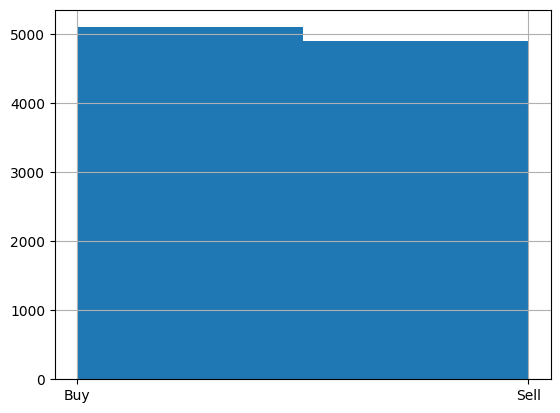

In [93]:
y.hist(bins=2);

## Train, test split
### Don't use train, test_split with shuffle because of information leakage between adjacent train-test-folds

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

In [59]:
#Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5. Train 

In [65]:
#Training the model
clf = RandomForestClassifier(n_estimators=30)#, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

In [61]:
y_pred = classifier.predict(X_test)
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))


Accuracy score of the model is:  0.507


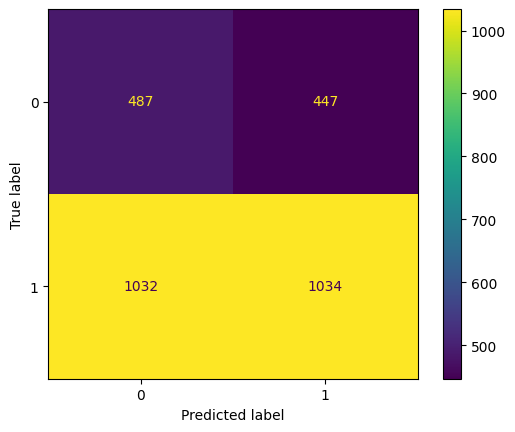

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix( y_pred, y_test);
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### hyper parameters

In [21]:
##SVM

In [63]:
clf = svm.SVC(kernel = 'linear', probability = True, C = 78, gamma = 25)
clf.fit(X_train, y_train)

SVC(C=78, gamma=25, kernel='linear', probability=True)

Accuracy score of the model is:  0.5033333333333333


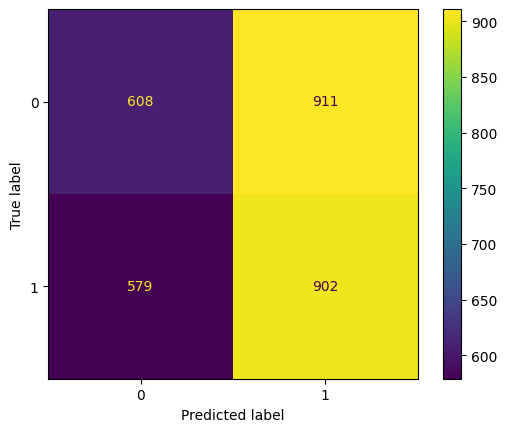

In [64]:
y_pred = clf.predict(X_test)  
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(  y_test, y_pred,);
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [66]:
prob = clf.predict_proba(X_test)

In [67]:
prob

array([[0.56666667, 0.43333333],
       [0.56666667, 0.43333333],
       [0.63333333, 0.36666667],
       ...,
       [0.5       , 0.5       ],
       [0.36666667, 0.63333333],
       [0.56666667, 0.43333333]])

In [82]:
inds = prob[:,0] > 0.6

X_prob = X_test[inds, :]
y_prob = y_test[inds]
X_prob.shape

(217, 102)

In [83]:
y_pred_2 = clf.predict(X_prob)  
#plt.hist(y_pred_1, bins=2);
print ("Accuracy score of the model is: ", accuracy_score(y_prob, y_pred_2))
#plot_confusion_matrix(clf, X_prob, y_prob);

Accuracy score of the model is:  0.5391705069124424


Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

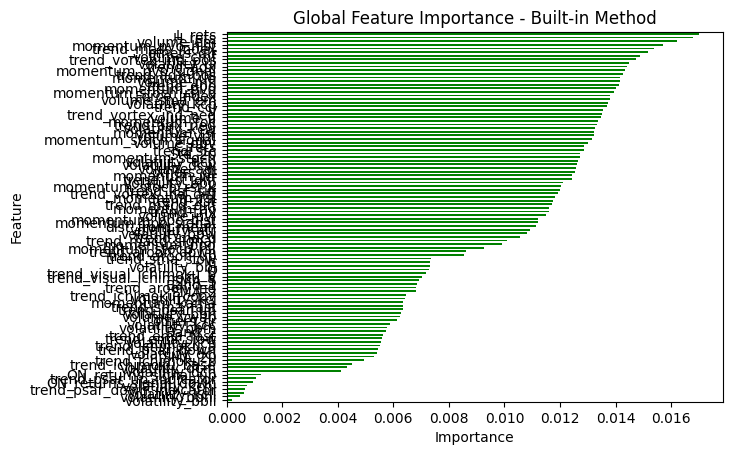

In [88]:
global_importances = pd.Series(clf.feature_importances_, index=X.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [147]:
from sklearn.naive_bayes import BernoulliNB

In [148]:
clf = BernoulliNB()
clf.fit(X_train,y_train)

BernoulliNB()

Accuracy score of the model is:  0.49533333333333335


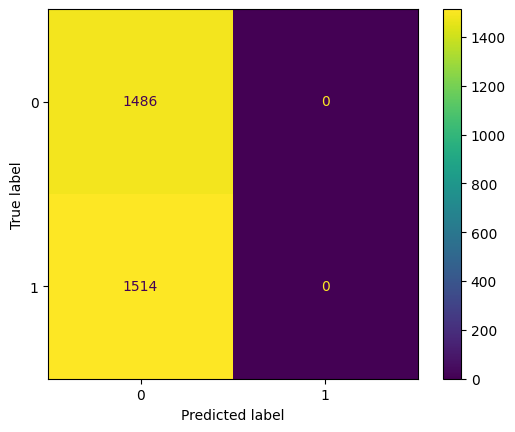

In [149]:
y_pred = clf.predict(X_test)  
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(  y_test, y_pred,);
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [68]:
pred_prob = clf.predict_proba(X_test)

Accuracy score of the model is:  0.5268817204301075


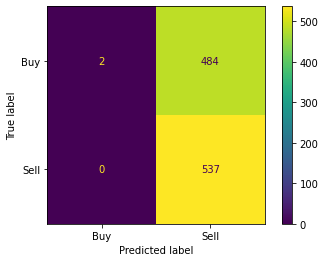

In [76]:
inds = ((pred_prob[:,0] > 0.53) | (pred_prob[:,1] > 0.53))

X_prob = X_test[inds, :]
y_prob = y_test[inds]

y_pred_prob = clf.predict(X_prob)  
print ("Accuracy score of the model is: ", accuracy_score(y_prob, y_pred_prob))
plot_confusion_matrix(clf, X_prob, y_prob);

## RidgeCV

In [150]:
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV, LogisticRegression
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

Accuracy score of the model is:  0.498


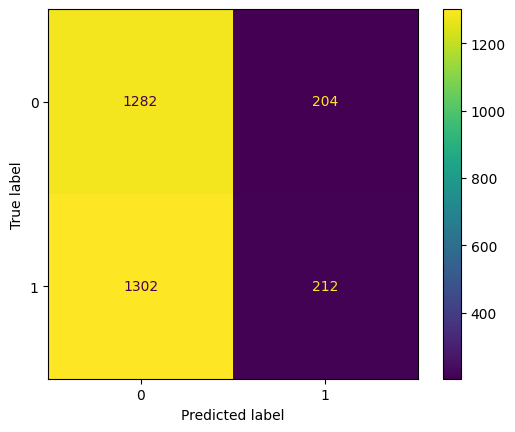

In [151]:
y_pred = clf.predict(X_test)  
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(  y_test, y_pred,);
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## LogisticRegressionCV

In [155]:
clf = LogisticRegressionCV(solver='liblinear',  multi_class='ovr',random_state=0)
clf.fit(X_train, y_train)

LogisticRegressionCV(multi_class='ovr', random_state=0, solver='liblinear')

Accuracy score of the model is:  0.496


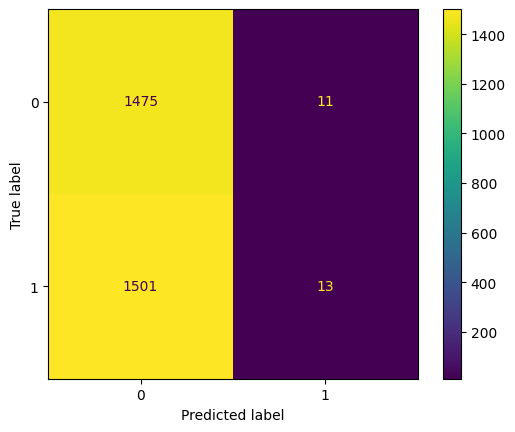

In [156]:
y_pred = clf.predict(X_test)  
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
cm = confusion_matrix(  y_test, y_pred,);
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [190]:
clf = LogisticRegression(solver='liblinear', C = 0.02, multi_class='ovr',random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=0.02, multi_class='ovr', random_state=0,
                   solver='liblinear')

Accuracy score of the model is:  0.5233333333333333


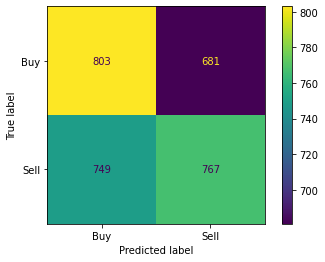

In [191]:
y_pred = clf.predict(X_test)  
print ("Accuracy score of the model is: ", accuracy_score(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test);

### 6. Validate